In [ ]:
#Importing and Installing Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from sklearn import preprocessing
import re

In [ ]:
#Importing Data
train = pd.read_csv('/content/drive/My Drive/ML-Project/train.csv')
val = pd.read_csv('/content/drive/My Drive/ML-Project/validation.csv')
test = pd.read_csv('/content/drive/My Drive/ML-Project/test.csv')
print(train.columns)

Index(['id', 'tweet', 'label'], dtype='object')


In [ ]:
#Encoding Label for "fake" and "real"
labelEncoder = preprocessing.LabelEncoder()
train['label'] = labelEncoder.fit_transform(train['label'])
val['label'] = labelEncoder.transform(val['label'])

In [ ]:
#Removing Links and mentions from tweets
def removeLinks(text):
  text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
  text = re.sub(r'@\S+', '', text)
  return text

train['tweet'] = train['tweet'].apply(lambda x: removeLinks(x))
val['tweet'] = val['tweet'].apply(lambda x: removeLinks(x))
test['tweet'] = test['tweet'].apply(lambda x: removeLinks(x))

In [ ]:
X_train = train.tweet
y_train = train.label
X_val = val.tweet
y_val = val.label
X_test = test.tweet

#Training Dataset
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train.values, tf.string),
            tf.cast(y_train.values, tf.int32)
        )
    )
)

#Validation Dataset
val_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_val.values, tf.string),
            tf.cast(y_val.values, tf.int32)
        )
    )
)

#Test Dataset
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test.values, tf.string)
        )
    )
)

print(train_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


In [ ]:
BATCH_SIZE = 4
BUFFER_SIZE = X_train.shape[0]
VOCAB_SIZE=2000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
#Creating the Model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
#Compiling the Model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
#Training the Model for 5 Epochs
history = model.fit(train_dataset, epochs=4,
                    validation_data=val_dataset)

Epoch 1/4
1070/1070 [==============================] - 28s 26ms/step - loss: 0.4591 - accuracy: 0.7553 - val_loss: 0.2787 - val_accuracy: 0.8855
Epoch 2/4
1070/1070 [==============================] - 24s 23ms/step - loss: 0.2161 - accuracy: 0.9157 - val_loss: 0.2378 - val_accuracy: 0.9014
Epoch 3/4
1070/1070 [==============================] - 24s 23ms/step - loss: 0.1614 - accuracy: 0.9397 - val_loss: 0.2428 - val_accuracy: 0.9107
Epoch 4/4
1070/1070 [==============================] - 24s 23ms/step - loss: 0.1237 - accuracy: 0.9550 - val_loss: 0.2641 - val_accuracy: 0.9070


In [ ]:
#Printing the Loss and Accuracy
test_loss, test_acc = model.evaluate(val_dataset)

print('Validation Loss:',test_loss)
print('Validation Accuracy:',test_acc)

357/357 [==============================] - 3s 7ms/step - loss: 0.2641 - accuracy: 0.9070
Validation Loss: 0.26408079266548157
Validation Accuracy: 0.9070093631744385


(0.0, 0.47583388835191726)

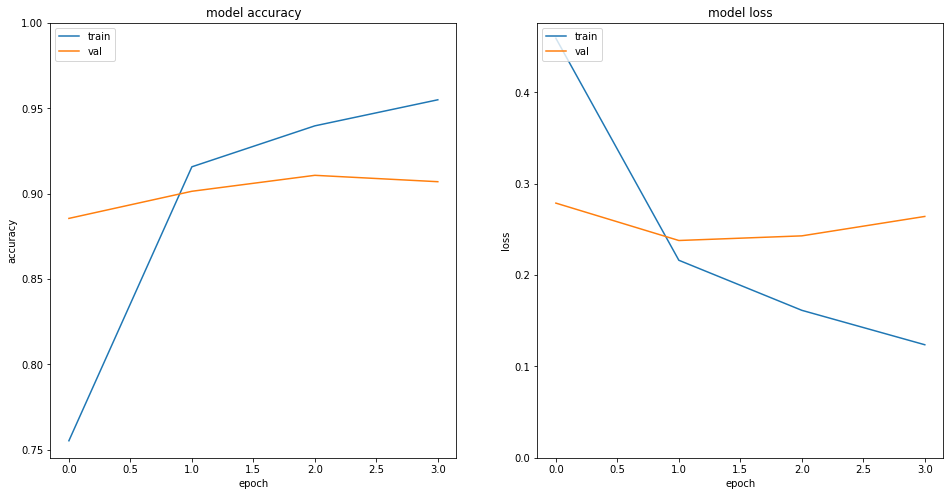

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(None,1)
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0,None)

In [ ]:
#Make Predictions
predictions = model.predict(test_dataset)
y_pred = []
for i in predictions[:,0]:
  if i>0:
    y_pred.append(1)
  else:
    y_pred.append(0)
print(y_pred)

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 

In [ ]:
sol = pd.DataFrame(test['id'], columns=['id'])
sol['label'] = labelEncoder.inverse_transform(y_pred)
sol.to_csv('/content/drive/My Drive/ML-Project/rnn_test.txt', index=False)